In [1]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string # for text manipulation 
import warnings 
import numpy as np 
import pandas as pd # for data manipulation 
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm

In [3]:
dataset_columns = ["target", "ids", "date", "flag", "user", "TweetText"]
dataset_encode = "ISO-8859-1"
data=pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = dataset_encode,names=dataset_columns)

In [4]:
data.head()

,target,ids,date,flag,user,TweetText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Let's keep only target variable and tweets text
data.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [6]:
positif_data = data[data.target==4].iloc[:10000,:]
print(positif_data.shape)
negative_data = data[data.target==0].iloc[:10000,:]
print(negative_data.shape)

(10000, 2)
(10000, 2)


In [7]:
tweet_df = pd.concat([positif_data,negative_data],axis = 0)
tweet_df['target'] = tweet_df['target'].replace(4,1)
print(tweet_df.shape)
tweet_df.head()

(20000, 2)


,target,TweetText
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


In [8]:
tweet_df.tail()

,target,TweetText
9995,0,Aww that's sad
9996,0,stupid dvds stuffing up the good bits in jaws.
9997,0,@Dandy_Sephy No. Only close friends and family...
9998,0,CRAP! After looking when I last tweeted... WHY...
9999,0,Its Another Rainboot day


In [9]:
#Check for missing values
100*tweet_df.isna().sum()/len(tweet_df)

target       0.0
TweetText    0.0
dtype: float64

In [10]:
stopwords=nltk.corpus.stopwords.words('english')

In [11]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [12]:
from nltk.stem.porter import PorterStemmer
def cleanup_tweets(tweet_df):
    # remove handle
    tweet_df['clean_tweet'] = tweet_df['TweetText'].str.replace("@", "") 
    # remove links
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].str.replace(r"http\S+", "") 
    # remove punctuations and special characters
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].str.replace("[^a-zA-Z]", " ") 
    # remove stop words
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda text : remove_stopwords(text.lower()))
    # split text and tokenize
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: x.split())
    # let's apply stemmer
    stemmer = PorterStemmer()
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
    # stitch back words
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x]))
    # remove small words
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


In [13]:
cleanup_tweets(tweet_df)

In [14]:
# function to display word clous
from wordcloud import WordCloud,STOPWORDS
def createWrdCloudForSentiment(target):
    temp_df = pd.DataFrame() 
    if target == -1:
        temp_df = tweet_df
    else:
        temp_df = tweet_df[tweet_df.target==target]
    words = " ".join(temp_df.clean_tweet)
    wrdcld = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1500,
                      height=1000).generate(words)
    plt.figure(figsize=(10,10))
    plt.imshow(wrdcld)
    plt.axis('off')
    plt.show

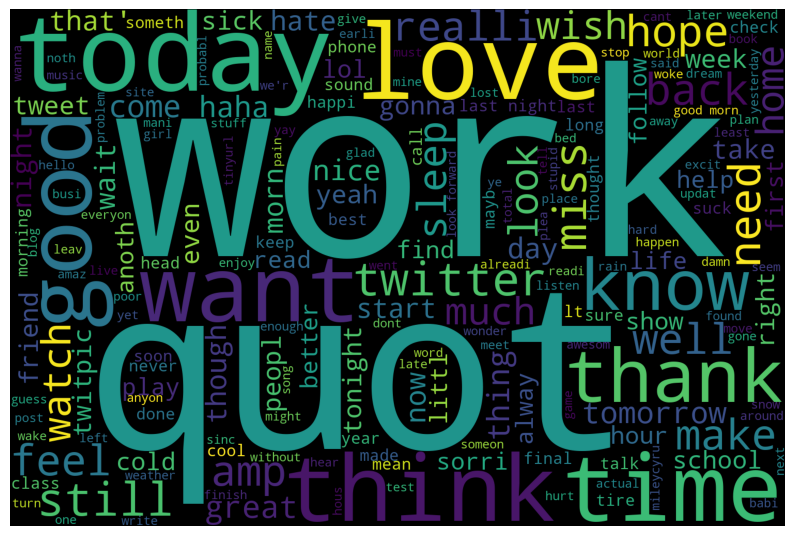

In [15]:
createWrdCloudForSentiment(-1)

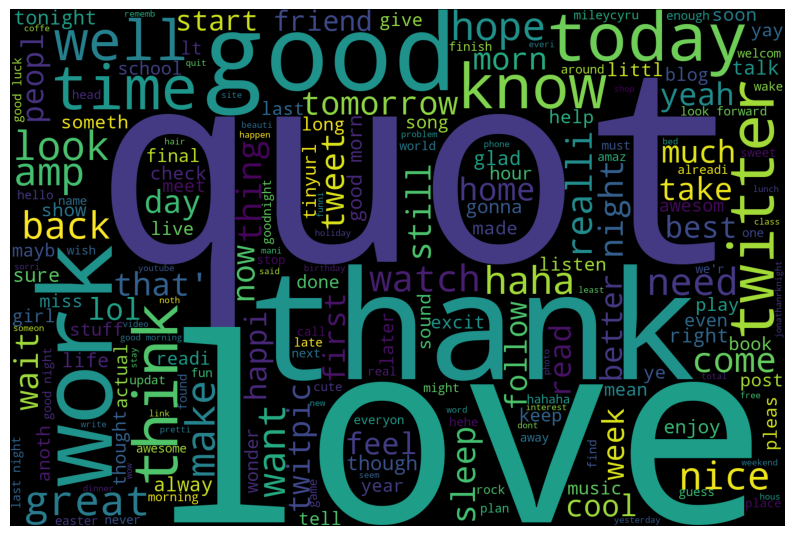

In [16]:
createWrdCloudForSentiment(1) 

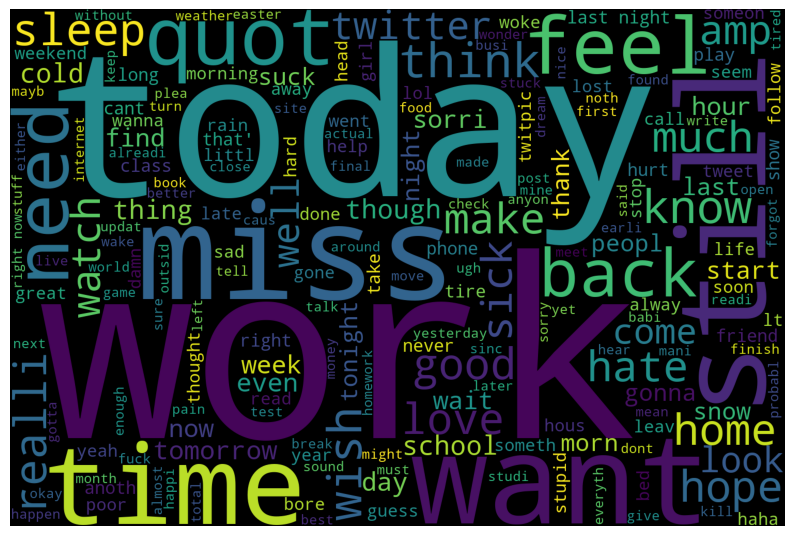

In [17]:
createWrdCloudForSentiment(0) 

In [18]:
# Data balance
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

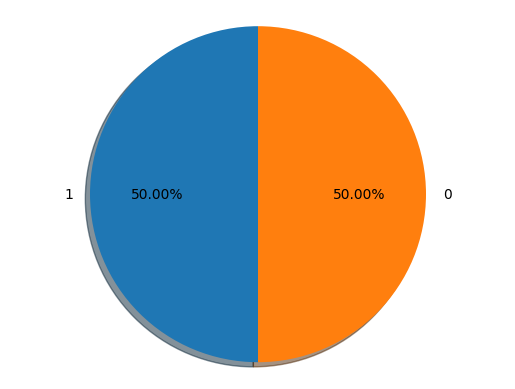

In [19]:
createPieChartFor(tweet_df.target)

In [20]:
train_df, test_df = train_test_split(tweet_df, test_size=0.3, random_state=42)

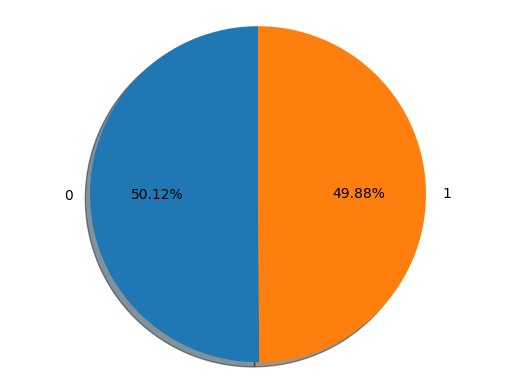

In [21]:
createPieChartFor(train_df.target)

In [22]:
# train_tweets =[]
# for tweet in train_df.clean_tweet:
#     train_tweets.append(tweet)
    
# test_tweets =[]
# for tweet in test_df.clean_tweet:
#     test_tweets.append(tweet)

In [23]:
# train_tweets[:10]

In [24]:
# print(f'train_tweets--{train_tweets}')

In [25]:
# print(f'tweet_df--{tweet_df}')
tweet_df.head(10)
tweet_df.tail()

,target,TweetText,clean_tweet
9995,0,Aww that's sad,that'
9996,0,stupid dvds stuffing up the good bits in jaws.,stupid stuf good jaws.
9997,0,@Dandy_Sephy No. Only close friends and family...,dandy_sephi close friend famili afraid. work c...
9998,0,CRAP! After looking when I last tweeted... WHY...,crap! look last tweeted... early. like...
9999,0,Its Another Rainboot day,anoth rainboot


In [26]:
tweet_df.head()
tweet_df.shape

(20000, 3)

In [27]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(TfidfVectorizer(),  svm.SVC())

In [28]:
from sklearn.model_selection import train_test_split
X = tweet_df['clean_tweet']
y = tweet_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(19000,) (1000,) (19000,) (1000,)


In [29]:
y_train.value_counts()

target
0    9511
1    9489
Name: count, dtype: int64

In [30]:
model = make_pipeline(TfidfVectorizer(),  svm.SVC())

In [31]:
model.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [32]:
validation = model.predict(X_test)

In [33]:
validation1 = model.predict(X_train)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, validation1)

0.9691052631578947

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, validation)

0.73

<Axes: >

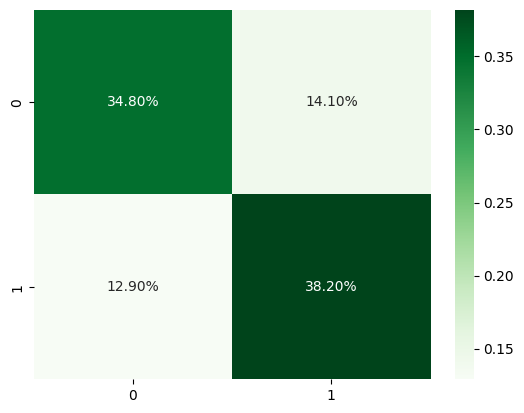

In [36]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, validation)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Greens')

In [37]:
print(classification_report(y_test, validation))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       489
           1       0.73      0.75      0.74       511

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



In [38]:
train = pd.DataFrame()
train['label'] = y_train
train['text'] = X_train

def predict_category(s, train=X_train, model=model):
    pred = model.predict([s])
    return pred[0]

In [40]:
predict_category("i wanna love myself")

0

c:\Users\curio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

0.7964452631578948

0.76244

<Axes: >

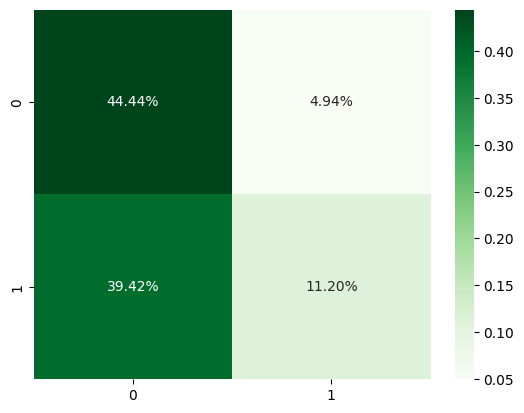

In [41]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, validation)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Greens')

In [42]:
print(classification_report(y_test, validation))

              precision    recall  f1-score   support

           0       0.53      0.90      0.67      2469
           1       0.69      0.22      0.34      2531

    accuracy                           0.56      5000
   macro avg       0.61      0.56      0.50      5000
weighted avg       0.61      0.56      0.50      5000



In [50]:
train = pd.DataFrame()
train['label'] = y_train
train['text'] = X_train

def predict_category(s, train=X_train, model=model2):
    pred = model2.predict([s])
    return pred[0]

In [52]:
predict_category("i wanna love myself")

1

In [41]:
import pickle
with open('sentiment_model_svm.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
model5 = make_pipeline(TfidfVectorizer(), svm.SVC())

In [ ]:
model5.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [27]:
validation = model4.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, validation1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, validation)

In [ ]:
train = pd.DataFrame()
train['label'] = y_train
train['text'] = X_train

def predict_category(s, train=X_train, model=model2):
    pred = model2.predict([s])
    return pred[0]

In [79]:
vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_tweets)
test_tfidf_model = vectorizer.transform(test_tweets)

In [25]:
train_tfidf = pd.DataFrame(train_tfidf_model.toarray(), columns=vectorizer.get_feature_names_out())
train_tfidf.head()

,00,000,0007,000kg,001,002,003,004,00am,00pm,...,½se,½so,½stand,½t,½tï,½v,½vno,½we,½y,½ï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=1000, random_state=42),
       KNeighborsClassifier(n_neighbors = 5),
       svm.SVC()]

cls_name = []

In [29]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

# List of classifiers
cls = [
    LogisticRegression(),
    MultinomialNB(), 
    DecisionTreeClassifier(),
    # KNeighborsClassifier(n_neighbors=5),
    svm.SVC()
]

# Classifier names
cls_names = [
    "LogisticRegression",
    "MultinomialNB",
    "DecisionTreeClassifier",
    # "KNeighborsClassifier",
    "SVM"
]

# Train each model and save
for cl, name in zip(cls, cls_names):
    model = cl.fit(train_tfidf_model, train_df.target)
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(model, file)
    print(f"{name} model saved as {name}.pkl")


LogisticRegression model saved as LogisticRegression.pkl
MultinomialNB model saved as MultinomialNB.pkl
DecisionTreeClassifier model saved as DecisionTreeClassifier.pkl
SVM model saved as SVM.pkl


In [30]:
def load_model(model_name):
    with open(f'{model_name}.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

# Example of loading and using a model
model_name = "DecisionTreeClassifier"
loaded_model = load_model(model_name)
lbl_pred = loaded_model.predict(test_tfidf_model)
accuracy = 100 * accuracy_score(lbl_pred, test_df.target)
print(f"{model_name} Accuracy Score: {accuracy:.2f}%")
print(classification_report(lbl_pred, test_df.target))

DecisionTreeClassifier Accuracy Score: 93.55%
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       267
           4       0.97      0.96      0.97      7533

    accuracy                           0.94      7800
   macro avg       0.55      0.56      0.56      7800
weighted avg       0.94      0.94      0.94      7800



In [31]:
# train = pd.DataFrame()
# train['label'] = y_train
# train['text'] = X_train

# def predict_category(s, train=X_train, model=model):
#     pred = model.predict([s])
#     return pred[0]

NameError: name 'y_train' is not defined

In [32]:
vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_tweets)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


In [33]:
def load_tfidf_vectorizer():
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        vectorizer = pickle.load(file)
    return vectorizer

def load_model(model_name):
    with open(f'{model_name}.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

In [34]:
vectoriser=load_tfidf_vectorizer()

In [35]:
def predict_sentiment(text, model_name):
    # Load the TF-IDF vectorizer and the model
    vectorizer = load_tfidf_vectorizer()
    model = load_model(model_name)
    
    # Transform the input text
    input_tfidf = vectorizer.transform([text])
    
    # Make a prediction
    prediction = model.predict(input_tfidf)[0]
    probability = model.predict_proba(input_tfidf)[0]
    
    return prediction, probability


In [37]:
predict_sentiment('love you',loaded_model)

FileNotFoundError: [Errno 2] No such file or directory: 'DecisionTreeClassifier().pkl'

In [42]:
def load_model(model_name):
    with open(f'LogisticRegression.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

In [43]:
lr_model = load_model(LogisticRegression)

In [44]:
predict_sentiment('love you',lr_model)

(4, array([0.00445709, 0.99554291]))

In [51]:
predict_sentiment('my whole body feels itchy and like its on fire ',lr_model)

(1, array([0.07309864, 0.92690136]))

In [46]:
def predict_sentiment(text, model):
    # Load the TF-IDF vectorizer
    vectorizer = load_tfidf_vectorizer()
    
    # Transform the input text
    input_tfidf = vectorizer.transform([text])
    
    # Make a prediction
    prediction = model.predict(input_tfidf)[0]
    probability = model.predict_proba(input_tfidf)[0]
    
    # Adjust the prediction to binary (0 or 1) based on probability threshold
    predicted_class = 1 if probability[1] > 0.5 else 0
    
    return predicted_class, probability

# if __name__ == "__main__":
#     # Load the Logistic Regression model
#     lr_model = load_model("LogisticRegression")

#     # Texts for prediction
#     texts = ["love you", "hate you"]

#     for text in texts:
#         # Predict sentiment
#         prediction, probability = predict_sentiment(text, lr_model)

#         print(f"Text: {text}")
#         print(f"Predicted Class: {prediction}")
#         print(f"Probability: {probability}")
#         print("---")


In [50]:
prediction, probability = predict_sentiment("I'm loving myself", lr_model)
print(f'prediction--{prediction},probability--{probability}')

prediction--1,probability--[0.03547304 0.96452696]
